# Summary

## Findings
* The wireless accommodation category has a low correlation
* Bedrooms are the most important feature

## Actions
* Wireless was removed
* I used step forward feature selection to choose 10 features

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Summary" data-toc-modified-id="Summary-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Summary</a></span><ul class="toc-item"><li><span><a href="#Findings" data-toc-modified-id="Findings-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Findings</a></span></li><li><span><a href="#Actions" data-toc-modified-id="Actions-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Actions</a></span></li></ul></li><li><span><a href="#Variance-threshold" data-toc-modified-id="Variance-threshold-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Variance threshold</a></span></li><li><span><a href="#Correlation" data-toc-modified-id="Correlation-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Correlation</a></span></li><li><span><a href="#Feature-Importance" data-toc-modified-id="Feature-Importance-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Feature Importance</a></span></li><li><span><a href="#Step-Forward-Feature-Selection" data-toc-modified-id="Step-Forward-Feature-Selection-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Step Forward Feature Selection</a></span></li></ul></div>

In [1]:
# Import needed libraries
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.ensemble import GradientBoostingRegressor
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
%matplotlib inline
sns.set()

# Display all rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

df = pd.read_pickle('data/listings_cleaned_processed.pkl')

model = GradientBoostingRegressor(n_estimators=50, n_iter_no_change=10)

In [2]:
X = df.drop(columns=['price', 'price_log'], axis=1)
y = df.price_log

In [3]:
def model_eval(X, y):
    model.fit(X, y)
    predict = model.predict(X)
    r2 = r2_score(y, predict)

    return r2


# Variance threshold

In [4]:
from sklearn.feature_selection import VarianceThreshold

def variance_threshold_selector(data, thresh=0.10):
    selector = VarianceThreshold(threshold=thresh)
    selector.fit(data)
    return data[data.columns[selector.get_support(indices=True)]]

<Figure size 432x288 with 0 Axes>

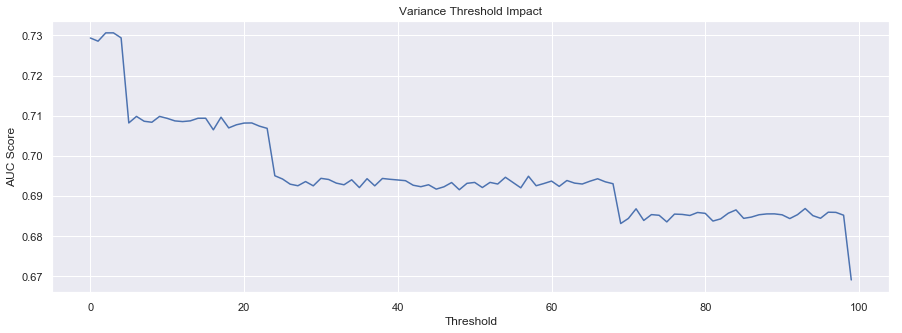

<Figure size 432x288 with 0 Axes>

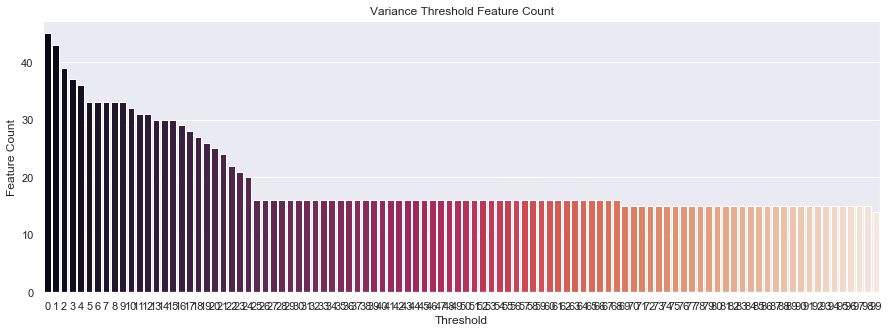

In [5]:
results = []
features = []
threshhold_num = list(range(0, 100, 1))
for i in threshhold_num:
    t = i/100
    new = variance_threshold_selector(X, thresh=t)
    features.append(new.shape[1])
    r2 = model_eval(new, y)
    results.append(r2)

plt.figure()
f, axes = plt.subplots(figsize=(15, 5))
plt.title('Variance Threshold Impact')
plt.xlabel("Threshold")
plt.ylabel("AUC Score")
sns.lineplot(y=results, x=threshhold_num)
plt.show()

plt.figure()
f, axes = plt.subplots(figsize=(15, 5))
plt.title('Variance Threshold Feature Count')
plt.xlabel("Threshold")
plt.ylabel("Feature Count")
sns.barplot(y=features, x=threshhold_num, palette="rocket")
plt.show()

# Correlation

In [6]:
# Set the threshold
threshold = 0.8

corrs = X.corr()

# Empty dictionary to hold correlated variables
above_threshold_vars = {}

# For each column, record the variables that are above the threshold
for col in corrs:
    above_threshold_vars[col] = list(corrs.index[corrs[col] > threshold])

In [7]:
# Track columns to remove and columns already examined
cols_to_remove = []
cols_seen = []
cols_to_remove_pair = []

# Iterate through columns and correlated columns
for key, value in above_threshold_vars.items():
    # Keep track of columns already examined
    cols_seen.append(key)
    for x in value:
        if x == key:
            next
        else:
            # Only want to remove one in a pair
            if x not in cols_seen:
                cols_to_remove.append(x)
                cols_to_remove_pair.append(key)
            
cols_to_remove = list(set(cols_to_remove))
print('Number of columns to remove: ', len(cols_to_remove))
print(cols_to_remove)

Number of columns to remove:  1
['Wireless']


In [8]:
# Code to remove the selected columns
df = df.drop(columns = cols_to_remove)

X = df.drop(columns=['price', 'price_log'], axis=1)
y = df.price_log

# Feature Importance

In [9]:
def plot_feature_importances(df, threshold = 0.9):
    """
    Plots 15 most important features and the cumulative importance of features.
    Prints the number of features needed to reach threshold cumulative importance.
    
    Parameters
    --------
    df : dataframe
        Dataframe of feature importances. Columns must be feature and importance
    threshold : float, default = 0.9
        Threshold for prining information about cumulative importances
        
    Return
    --------
    df : dataframe
        Dataframe ordered by feature importances with a normalized column (sums to 1)
        and a cumulative importance column
    
    """
    
    plt.rcParams['font.size'] = 18
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()
    df['cumulative_importance'] = np.cumsum(df['importance_normalized'])

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    # Cumulative importance plot
    plt.figure(figsize = (8, 6))
    plt.plot(list(range(len(df))), df['cumulative_importance'], 'r-')
    plt.xlabel('Number of Features'); plt.ylabel('Cumulative Importance'); 
    plt.title('Cumulative Feature Importance');
    plt.show();
    
    importance_index = np.min(np.where(df['cumulative_importance'] > threshold))
    print('%d features required for %0.2f of cumulative importance' % (importance_index + 1, threshold))
    
    return df

In [10]:
model.fit(X, y)

feature_importances = model.feature_importances_
feature_importances = pd.DataFrame({'feature': list(
    X.columns), 'importance': feature_importances}).sort_values('importance', ascending=False)

feature_importances.head()

,feature,importance
6,bedrooms,0.409992
8,cleaning_fee,0.140108
4,accommodates,0.122635
5,bathrooms,0.103964
65,room_type_Shared room,0.074575


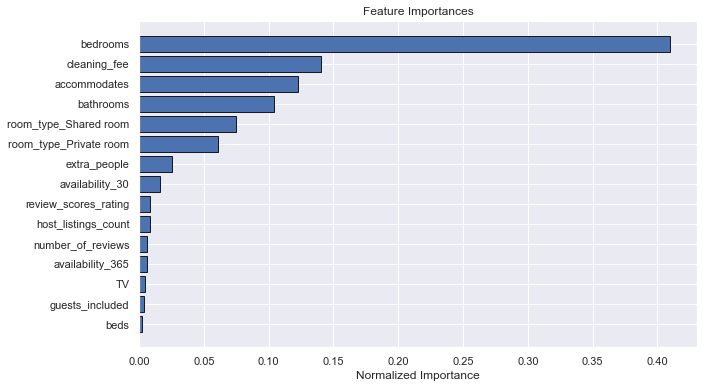

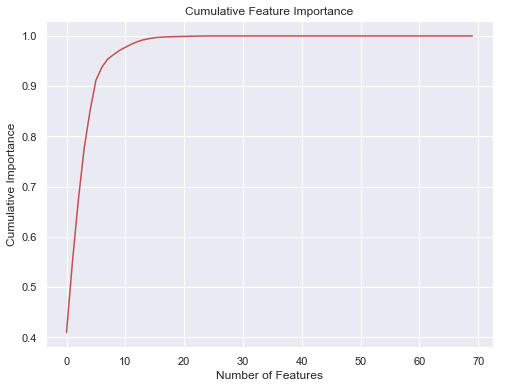

6 features required for 0.90 of cumulative importance


In [11]:
features = plot_feature_importances(feature_importances)

# Step Forward Feature Selection

In [12]:
from mlxtend.feature_selection import SequentialFeatureSelector as sfs

# Build step forward feature selection
sfs1 = sfs(model,
           k_features=10,
           forward=True,
           floating=False,
           verbose=2,
           scoring='r2',
           cv=5)

# Perform SFFS
sfs1 = sfs1.fit(X, y)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:   18.9s finished

[2020-01-25 12:09:48] Features: 1/10 -- score: 0.45739982542301805[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  69 out of  69 | elapsed:  1.0min finished

[2020-01-25 12:10:50] Features: 2/10 -- score: 0.5822278980783647[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  68 out of  68 | elapsed:  1.5min finished

[2020-01-25 12:12:19] Features: 3/10 -- score: 0.6125729792241492[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 

In [13]:
# Which features?
feat_cols = list(sfs1.k_feature_idx_)
print(feat_cols)

[2, 4, 5, 6, 8, 10, 13, 16, 64, 65]


In [14]:
cols = list(sfs1.k_feature_names_)

df_final = df[cols].join(y)

In [15]:
df_final.to_pickle('data/listings_cleaned_processed_stepForward.pkl')